#### Imports. Loading the Data. 

In [6]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from skimage.io import imread


# Setting the paths to the data
base_dir = "/Users/irenzo/Desktop/test_task"
train_dir = os.path.join(base_dir, "train_v2")
test_dir = os.path.join(base_dir, "test_v2")
train_csv_path = os.path.join(base_dir, "train_ship_segmentations_v2.csv")
test_csv_path = os.path.join(base_dir, "sample_submission_v2.csv")

# Loading the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Displaying the first few rows of the dataframes
print("Train data:")
print(train_df.head())
print("\nTest data:")
print(test_df.head())

# Loading a sample image
sample_image_path = os.path.join(train_dir, train_df.iloc[0]['ImageId'])
sample_image = Image.open(sample_image_path)
sample_image.show()

Train data:
         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

Test data:
         ImageId EncodedPixels
0  00002bd58.jpg           1 2
1  00015efb6.jpg           1 2
2  00023d5fc.jpg           1 2
3  000367c13.jpg           1 2
4  0008ca6e9.jpg           1 2


#### Exploring the Data:

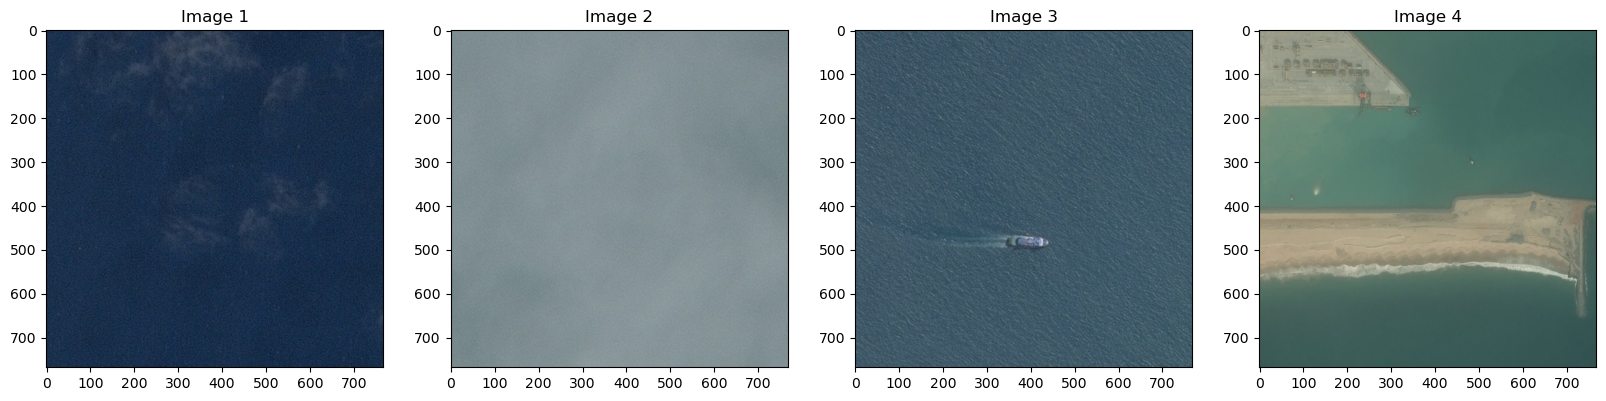

In [19]:
# Visualizing some sample images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    image_id = train_df.iloc[i]['ImageId']
    image_path = os.path.join(train_dir, image_id)
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title(f"Image {i+1}")
plt.show()

#### Descriptive Statistics

In [31]:
# Calculating total number of unique images
total_images = train_df['ImageId'].nunique()

# Identifying images with and without ships
# An image is considered to have ships if at least one of its 'EncodedPixels' entries is not null
has_ships = train_df.dropna(subset=['EncodedPixels'])
images_with_ships = has_ships['ImageId'].nunique()
images_without_ships = total_images - images_with_ships

# Calculating proportions
prop_with_ships = images_with_ships / total_images
prop_without_ships = images_without_ships / total_images

# Calculating the average number of ships per image (for images with ships)
# This counts the number of non-null 'EncodedPixels' entries per image and then computes the average
avg_ships_per_image_with_ships = has_ships.groupby('ImageId').size().mean()

# Calculating the overall average number of ships per image (including images without ships)
overall_avg_ships_per_image = has_ships.shape[0] / total_images

# Displaying the statistics
print(f"Total number of images: {total_images}")
print(f"Number of images with ships: {images_with_ships}")
print(f"Number of images without ships: {images_without_ships}")
print(f"Proportion of images with ships: {prop_with_ships:.2f}")
print(f"Proportion of images without ships: {prop_without_ships:.2f}")
print(f"Average number of ships per image (for images with ships): {avg_ships_per_image_with_ships:.2f}")
print(f"Overall average number of ships per image: {overall_avg_ships_per_image:.2f}")

#Showing column names in the dataframe
train_df.head()

Total number of images: 192556
Number of images with ships: 42556
Number of images without ships: 150000
Proportion of images with ships: 0.22
Proportion of images without ships: 0.78
Average number of ships per image (for images with ships): 1.92
Overall average number of ships per image: 0.42


ImageId                                      EncodedPixels  ShipSize  \
0  00003e153.jpg                                                NaN       NaN   
1  0001124c7.jpg                                                NaN       NaN   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...    3388.0   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...     177.0   
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...     148.0   

   HasShip  
0    False  
1    False  
2     True  
3     True  
4     True

#### Distribution of Ships per Image

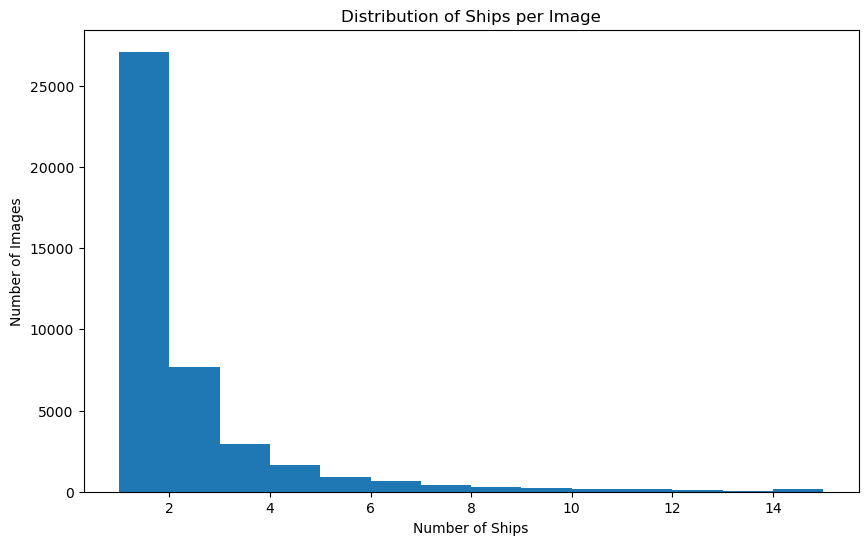

In [16]:
# Counting the number of ships per image
ships_count_per_image = train_df.dropna(subset=['EncodedPixels']).groupby('ImageId').size()

# Plotting the distribution of ships per image
plt.figure(figsize=(10, 6))
ships_count_per_image.hist(bins=range(1, ships_count_per_image.max() + 1))
plt.title('Distribution of Ships per Image')
plt.xlabel('Number of Ships')
plt.ylabel('Number of Images')
plt.grid(False)
plt.show()

#### Size Distribution of Ships

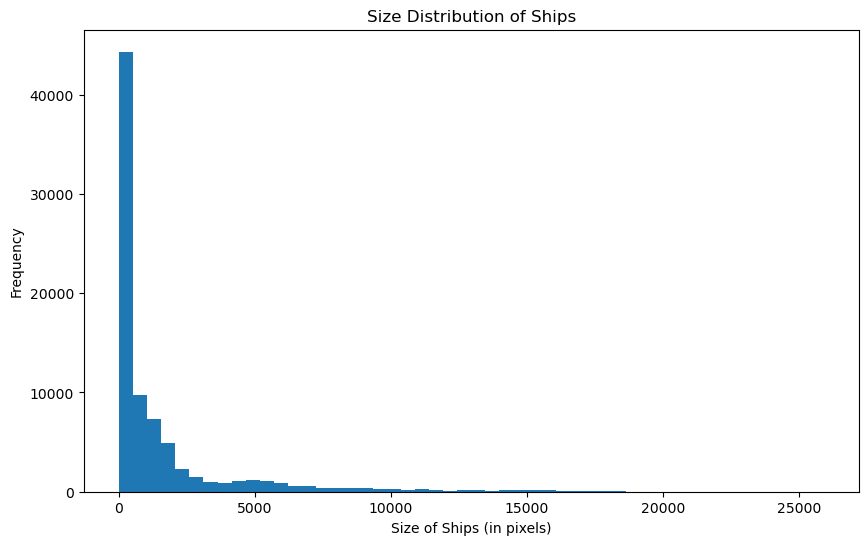

In [17]:
def decode_rle(encoded_pixels):
    counts = list(map(int, encoded_pixels.split()[1::2]))
    return sum(counts)

# Approximating the size of ships from 'EncodedPixels'
train_df['ShipSize'] = train_df['EncodedPixels'].dropna().apply(decode_rle)

# Plotting the size distribution of ships
plt.figure(figsize=(10, 6))
train_df['ShipSize'].hist(bins=50)
plt.title('Size Distribution of Ships')
plt.xlabel('Size of Ships (in pixels)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

#### Distribution of Image Brightness or Color

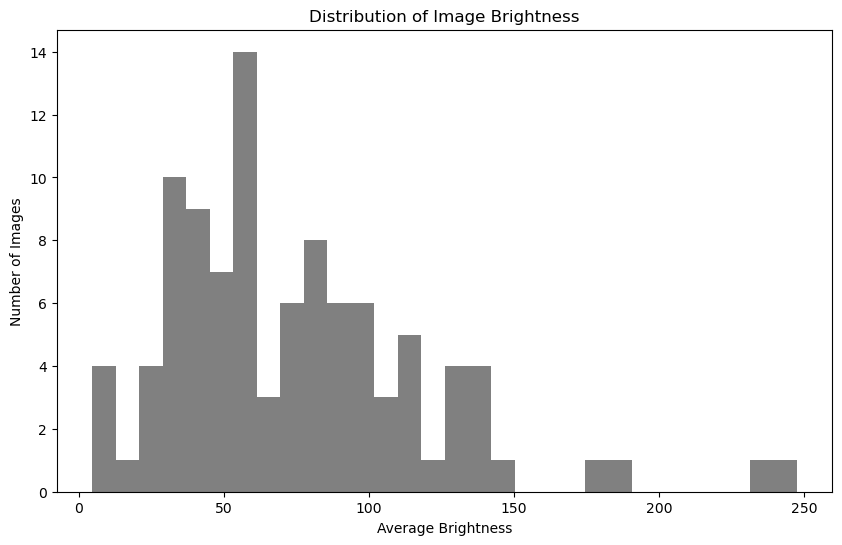

In [18]:
# Converting the image to grayscale and calculating the mean
def calculate_brightness(image):
    gray_image = image.convert('L')
    np_image = np.array(gray_image)
    return np.mean(np_image)

# Sampling a subset of images to calculate brightness
sample_images = train_df['ImageId'].drop_duplicates().sample(n=100, random_state=42)
brightness_values = []

for image_id in sample_images:
    image_path = os.path.join(train_dir, image_id)
    image = Image.open(image_path)
    brightness = calculate_brightness(image)
    brightness_values.append(brightness)

# Plotting the distribution of image brightness
plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=30, color='gray')
plt.title('Distribution of Image Brightness')
plt.xlabel('Average Brightness')
plt.ylabel('Number of Images')
plt.grid(False)
plt.show()

#### Decode Encoded Pixels into Masks

In [20]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle is np.nan:
        return np.zeros(shape[0]*shape[1], dtype=np.uint8).reshape(shape).T
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

#### Overlaying Masks on Images and Visualizing them

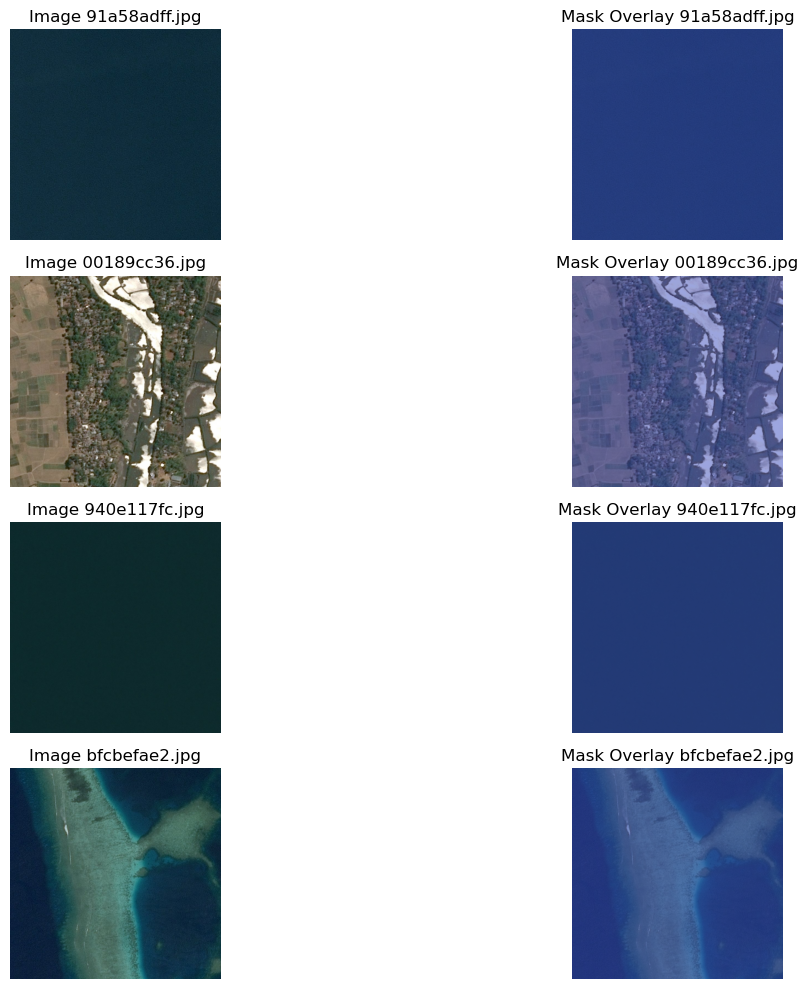

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_images_with_masks(sample_ids, base_dir, dataframe):
    plt.figure(figsize=(15, 10))
    
    for i, image_id in enumerate(sample_ids):
        image_path = os.path.join(base_dir, image_id)
        image = Image.open(image_path)
        
        rle_masks = dataframe[dataframe['ImageId'] == image_id]['EncodedPixels']
        
        # Creating an empty mask placeholder
        full_mask = np.zeros((768, 768), dtype=np.uint8)
        
        # Looping through all masks for the current image and adding them to the full_mask
        for mask in rle_masks.dropna():
            full_mask += rle_decode(mask)
        
        # Clipping the mask to binary (in case of overlapping masks)
        full_mask = np.clip(full_mask, 0, 1)
        
        # Plotting the image
        plt.subplot(len(sample_ids), 2, i*2 + 1)
        plt.imshow(image)
        plt.title(f"Image {image_id}")
        plt.axis('off')
        
        # Plotting the image with mask overlay
        plt.subplot(len(sample_ids), 2, i*2 + 2)
        plt.imshow(image)
        plt.imshow(full_mask, cmap='coolwarm', alpha=0.5)
        plt.title(f"Mask Overlay {image_id}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Sample a few image IDs to visualize
sample_ids = train_df['ImageId'].drop_duplicates().sample(n=4, random_state=42).values

show_images_with_masks(sample_ids, train_dir, train_df)


#### Decoding RLE Masks

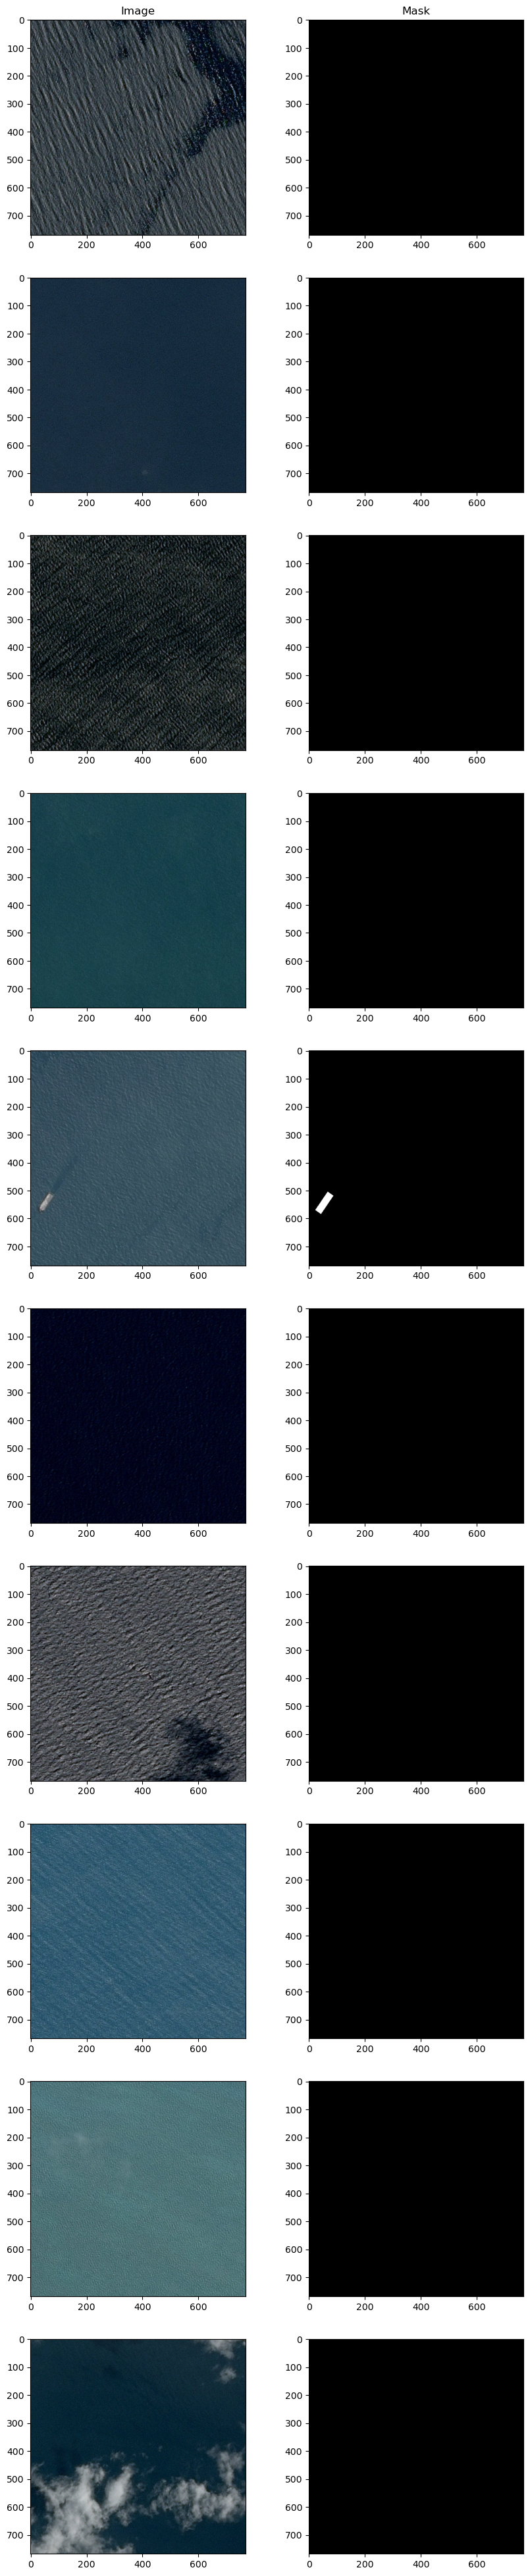

In [21]:
def rle_decode(mask_rle, shape=(768, 768)):
    if pd.isnull(mask_rle):
        return np.zeros(shape)
    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]
    starts = np.array(starts) - 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1
    return img.reshape(shape).T

def image_mask_generator(image_ids, batch_size, base_dir, dataframe):
    while True:
        batch_ids = np.random.choice(image_ids, batch_size)
        batch_images = []
        batch_masks = []
        for image_id in batch_ids:
            image_path = os.path.join(base_dir, "train_v2", image_id)
            image = Image.open(image_path)
            image_np = np.array(image) / 255.0
            
            rle_masks = dataframe[dataframe['ImageId'] == image_id]['EncodedPixels']
            mask = np.zeros((768, 768))
            for rle_mask in rle_masks.dropna():
                mask += rle_decode(rle_mask)
            mask = np.clip(mask, 0, 1)
            
            batch_images.append(image_np)
            batch_masks.append(mask.reshape(768, 768, 1))
        
        yield np.array(batch_images), np.array(batch_masks)

# Setting up data augmentation configuration
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_ids = train_df['ImageId'].unique()

batch_size = 10
base_dir = "/Users/irenzo/Desktop/test_task"
# Creatting the generator
gen = image_mask_generator(image_ids, batch_size, base_dir, train_df)

# Generatting a batch of images and masks
images, masks = next(gen)

# Visualizing the generated batch
fig, axes = plt.subplots(batch_size, 2, figsize=(10, batch_size * 5))
for i in range(batch_size):
    axes[i, 0].imshow(images[i])
    axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
axes[0, 0].set_title("Image")
axes[0, 1].set_title("Mask")
plt.show()